# Delta Function

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [8]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

np.random.seed(42)

In [9]:
import os

if os.path.isdir("../notebooks/"):
    os.chdir("../abm/")


from utils import viz

from agent import Person

from model import VirusModel, VirusModel_baseline


## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

wealth by race https://www.federalreserve.gov/econres/notes/feds-notes/disparities-in-wealth-by-race-and-ethnicity-in-the-2019-survey-of-consumer-finances-20200928.html

rank for the US:
https://www.federalreserve.gov/econres/notes/feds-notes/wealth-inequality-and-the-racial-wealth-gap-accessible-20211022.htm#fig3


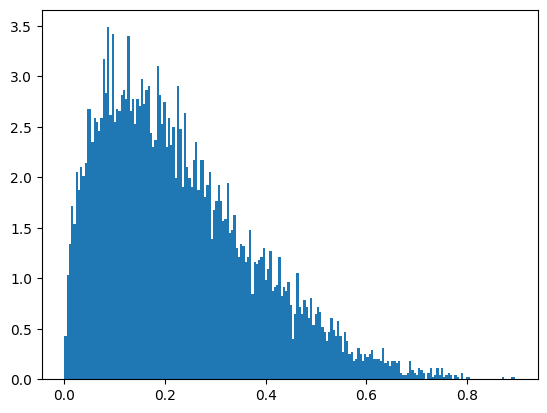

In [11]:
values = plt.hist(np.random.beta(1.5, 5, 10000),

                  bins=200, density=True)

plt.show()

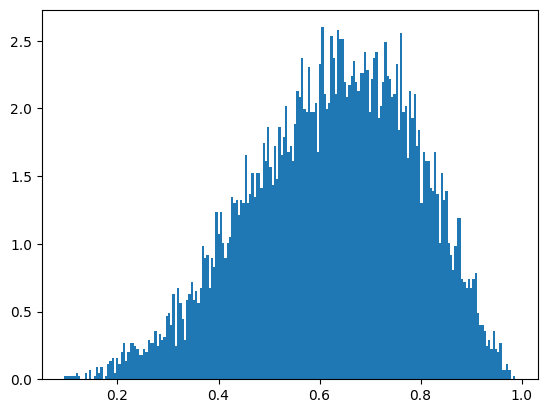

In [12]:
import matplotlib.pyplot as plt

values = plt.hist(np.random.beta(5, 3, 10000),

                  bins=200, density=True)

plt.show()

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

Completed: 100 steps
Run time: 0:00:01.798298
Simulation finished


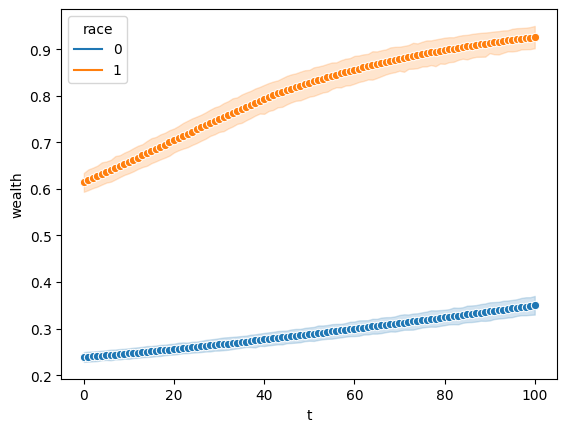

In [13]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

Completed: 100 steps
Run time: 0:00:02.935420
Simulation finished


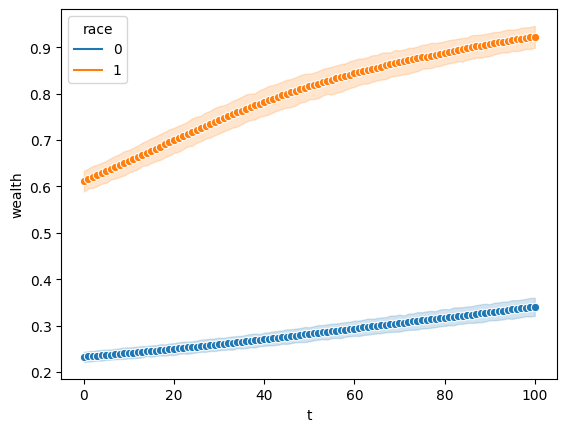

In [14]:
parameters = {
    'my_parameter':42,
    'agents':1000,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.2 # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    
}

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [15]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [16]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_52738/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_52738/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


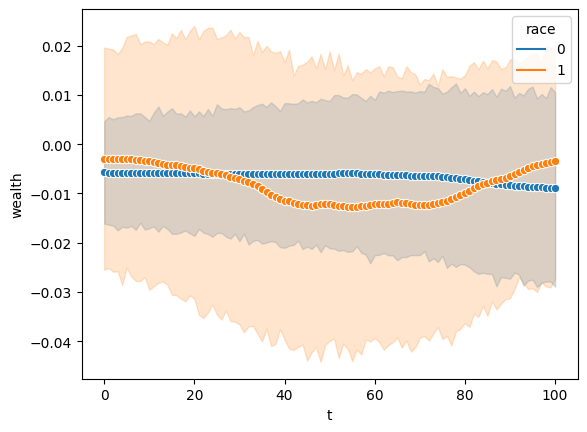

In [17]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [18]:
# run baseline and normal model and save results
model_baseline = VirusModel_baseline(parameters)
results_baseline = model_baseline.run() 

df_baseline = results_baseline['variables']['Person']

model = VirusModel(parameters)
results = model.run() 

df = results['variables']['Person']

Completed: 100 steps
Run time: 0:00:01.764066
Simulation finished
Completed: 100 steps
Run time: 0:00:02.888409
Simulation finished


In [19]:
# create baseline value
def delta_function(disc_axis, df, df_baseline):
    df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
    df_wb1 = df.iloc[(df[disc_axis] == 1).values] ['wealth'] - df_b1.groupby(level='t').mean()['wealth']
    df_x1['wealth'] = df_wb1
    
    df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
    df_wb0 = df.iloc[(df[disc_axis] == 0).values] ['wealth'] - df_b0.groupby(level='t').mean()['wealth']
    df_x0['wealth'] = df_wb0

    df_xb = pd.concat([df_x0, df_x1])
    
    return df_xb

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_52738/642462805.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_52738/642462805.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


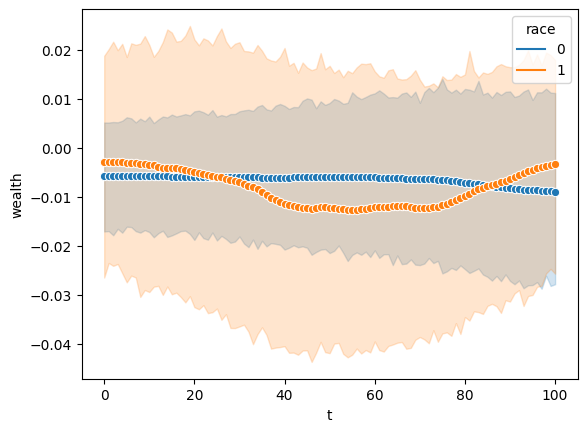

In [20]:
delta_function('race',df, df_baseline)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more? This
